<a href="https://colab.research.google.com/github/bsryu-personal/ASK2026_Semiconductor_Process/blob/main/%EC%A0%84%EC%B2%98%EB%A6%AC_%EC%B6%94%EB%A1%A0%EA%B0%9C%EC%84%A0_%ED%8A%B9%EC%A0%95Feature%EB%A7%8C%EB%B0%98%EC%98%81_LOF_iF_260222.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
'''
데이터 전처리/함수정의
'''
#1. 드라이브 연결

from google.colab import drive
import os

drive.mount('/content/drive')

#2. 파라미터 설정, 데이터 로드, 데이터셋 분리
#모든 실험을 통합하여 데이터셋 구성

# ==========================================
# 1. 라이브러리 및 환경 설정
# ==========================================
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix
import os
import warnings

warnings.filterwarnings('ignore')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ==========================================
# 2. 통합 데이터 전처리 (Unified Dataset)
# ==========================================
file_path = "/content/drive/MyDrive/2026Conv_FDC/MACHINE_Data.xlsx"
if os.path.exists(file_path):
    df = pd.read_excel(file_path) if file_path.endswith('.xlsx') else pd.read_csv(file_path)
else:
    df = pd.DataFrame()

sensor_cols = [
    'BCl3 Flow', 'Cl2 Flow', 'RF Btm Pwr', 'RF Btm Rfl Pwr', 'Endpt A',
    'He Press', 'Pressure', 'RF Tuner', 'RF Load', 'RF Phase Err',
    'RF Pwr', 'RF Impedance', 'TCP Tuner', 'TCP Phase Err',
    'TCP Impedance', 'TCP Top Pwr', 'TCP Rfl Pwr', 'TCP Load', 'Vat Valve'
]

def create_sequences_with_ids(df_target, wafer_col, sensor_cols, seq_len, scaler=None, is_train=True):
    data_values = df_target[sensor_cols].values
    if is_train:
        if scaler is None: scaler = MinMaxScaler()
        data_scaled = scaler.fit_transform(data_values)
    else:
        data_scaled = scaler.transform(data_values)

    df_scaled = pd.DataFrame(data_scaled, columns=sensor_cols, index=df_target.index)
    df_scaled[wafer_col] = df_target[wafer_col].values

    all_sequences, all_wafer_ids = [], []
    for wafer in df_scaled[wafer_col].unique():
        wafer_data = df_scaled[df_scaled[wafer_col] == wafer][sensor_cols].values
        if len(wafer_data) < seq_len: continue
        for i in range(len(wafer_data) - seq_len + 1):
            all_sequences.append(wafer_data[i : i + seq_len])
            all_wafer_ids.append(wafer)

    if len(all_sequences) == 0: return np.array([]), np.array([]), scaler
    return np.array(all_sequences), np.array(all_wafer_ids), scaler



# --- 데이터 통합 및 분할 ---
datasets = {}
target_experiments = ['l29', 'l31', 'l33']
SEQ_LEN = 32
TRAIN_RATIO = 0.7

print(f"🚀 Creating Unified Dataset from: {target_experiments}")

# 통합 데이터 필터링
combined_mask = df['Wafer_ID'].str.contains('|'.join(target_experiments), case=False, na=False)
combined_df = df[combined_mask]

# ID 셔플 및 분할
all_normal_ids = combined_df[combined_df['Label'] == 'Normal']['Wafer_ID'].unique()
all_fault_ids = combined_df[combined_df['Label'] == 'Fault']['Wafer_ID'].unique()

np.random.seed(42)
np.random.shuffle(all_normal_ids)

n_train = int(len(all_normal_ids) * TRAIN_RATIO)
train_ids = all_normal_ids[:n_train]
test_norm_ids = all_normal_ids[n_train:]

# 데이터프레임 분할
df_train = combined_df[combined_df['Wafer_ID'].isin(train_ids)]
df_test_norm = combined_df[combined_df['Wafer_ID'].isin(test_norm_ids)]
df_test_fault = combined_df[combined_df['Wafer_ID'].isin(all_fault_ids)]

# 시퀀스 생성
X_train, ids_train, global_scaler = create_sequences_with_ids(df_train, 'Wafer_ID', sensor_cols, SEQ_LEN, scaler=None, is_train=True)
X_test_norm, ids_test_norm, _ = create_sequences_with_ids(df_test_norm, 'Wafer_ID', sensor_cols, SEQ_LEN, scaler=global_scaler, is_train=False)
X_test_fault, ids_test_fault, _ = create_sequences_with_ids(df_test_fault, 'Wafer_ID', sensor_cols, SEQ_LEN, scaler=global_scaler, is_train=False)

# 사용자가 제공한 get_data_loaders 함수가 작동하도록 딕셔너리에 저장
datasets['Unified'] = {
    'X_train': X_train,
    'X_test_norm': X_test_norm,
    'ids_test_norm': ids_test_norm,
    'X_test_fault': X_test_fault,
    'ids_test_fault': ids_test_fault
}
print("✅ Unified Dataset Prepared.")

#3. 함수 정의

# ==========================================
# 3. 유틸리티 함수 (데이터 로드, 집계, 시각화)
# ==========================================
def get_data_loaders(exp_id, datasets_dict, batch_size=32):
    print(f"\n📊 [Data Setup] Experiment: {exp_id}")
    data = datasets_dict[exp_id]

    # 데이터 추출
    X_train = data['X_train']
    X_test_norm = data['X_test_norm']
    ids_test_norm = data['ids_test_norm']
    X_test_fault = data['X_test_fault']
    ids_test_fault = data['ids_test_fault']

    # Tensor 변환
    train_tensor = torch.FloatTensor(X_train).to(device)
    test_norm_tensor = torch.FloatTensor(X_test_norm).to(device)

    if len(X_test_fault) > 0:
        test_fault_tensor = torch.FloatTensor(X_test_fault).to(device)
    else:
        test_fault_tensor = torch.FloatTensor([]).to(device)

    # DataLoader (Train only)
    train_loader = DataLoader(TensorDataset(train_tensor), batch_size=batch_size, shuffle=True)

    return train_loader, (test_norm_tensor, ids_test_norm), (test_fault_tensor, ids_test_fault)

def aggregate_wafer_scores(window_scores, wafer_ids, method='max'):
    # DataFrame핑하여 GroupBy 연산
    df_temp = pd.DataFrame({'Wafer_ID': wafer_ids, 'Score': window_scores})

    if method == 'max':
        grouped = df_temp.groupby('Wafer_ID')['Score'].max()
    else:
        grouped = df_temp.groupby('Wafer_ID')['Score'].mean()

    return grouped.index.values, grouped.values

def visualize_results(model_name, exp_id, scores, labels, threshold):
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    plt.suptitle(f"[{exp_id}] {model_name} Performance (Wafer-Level)", fontsize=16, fontweight='bold')

    # Confusion Matrix
    preds = (scores > threshold).astype(int)
    cm = confusion_matrix(labels, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0],
                xticklabels=['Normal', 'Fault'], yticklabels=['Normal', 'Fault'])
    axes[0].set_title("Confusion Matrix")

    # Scatter Plot (Wafer Scores)
    normal_idx = np.where(labels == 0)[0]
    fault_idx = np.where(labels == 1)[0]

    axes[1].scatter(normal_idx, scores[normal_idx], color='blue', label='Normal', alpha=0.6, s=20)
    axes[1].scatter(fault_idx, scores[fault_idx], color='red', label='Fault', alpha=0.6, s=20)
    axes[1].axhline(y=threshold, color='green', linestyle='--', label='Threshold')
    axes[1].set_title("Wafer Anomaly Scores")
    axes[1].legend()

    # ROC Curve
    fpr, tpr, _ = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)
    axes[2].plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.4f}')
    axes[2].plot([0, 1], [0, 1], color='navy', linestyle='--')
    axes[2].set_title("ROC Curve")
    axes[2].legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def evaluate_performance(model_name, exp_id, scores, labels):
    precision, recall, thresholds = precision_recall_curve(labels, scores)
    with np.errstate(divide='ignore', invalid='ignore'):
        f1_scores = 2 * recall * precision / (recall + precision)
    f1_scores = np.nan_to_num(f1_scores)

    best_idx = np.argmax(f1_scores)
    best_f1 = f1_scores[best_idx]
    best_thresh = thresholds[best_idx]

    fpr, tpr, _ = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)

    print(f"\n📌 [{model_name} - {exp_id}] Wafer-Level Summary")
    print(f"   - AUROC         : {roc_auc:.4f}")
    print(f"   - Best F1-Score : {best_f1:.4f}")
    print(f"   - Best Threshold: {best_thresh:.6f}")

    visualize_results(model_name, exp_id, scores, labels, best_thresh)
    return roc_auc, best_f1


Mounted at /content/drive
Using device: cpu
🚀 Creating Unified Dataset from: ['l29', 'l31', 'l33']
✅ Unified Dataset Prepared.


✅ 분석에 사용할 최종 핵심 센서 10개 선정 완료
📊 선택된 센서: ['RF Impedance', 'TCP Load', 'RF Tuner', 'Endpt A', 'RF Load', 'Pressure', 'RF Phase Err', 'TCP Impedance', 'TCP Phase Err', 'TCP Top Pwr']

🚀 [Phase 1] 모델 학습 시작 (10개 Features 적용)...
✅ 학습 완료: 10개 센서의 세그먼트별 LOF 분포를 학습했습니다.

🔍 [Phase 2] 테스트 데이터 평가 시작...
📈 웨이퍼 레벨 점수 집계 중...

          CPD-LOF-IsoForest PERFORMANCE REPORT (10 Features)

📌 [CPD-LOF-IsoForest_v2 - Unified_Selected_10] Wafer-Level Summary
   - AUROC         : 0.8124
   - Best F1-Score : 0.7451
   - Best Threshold: -0.120068


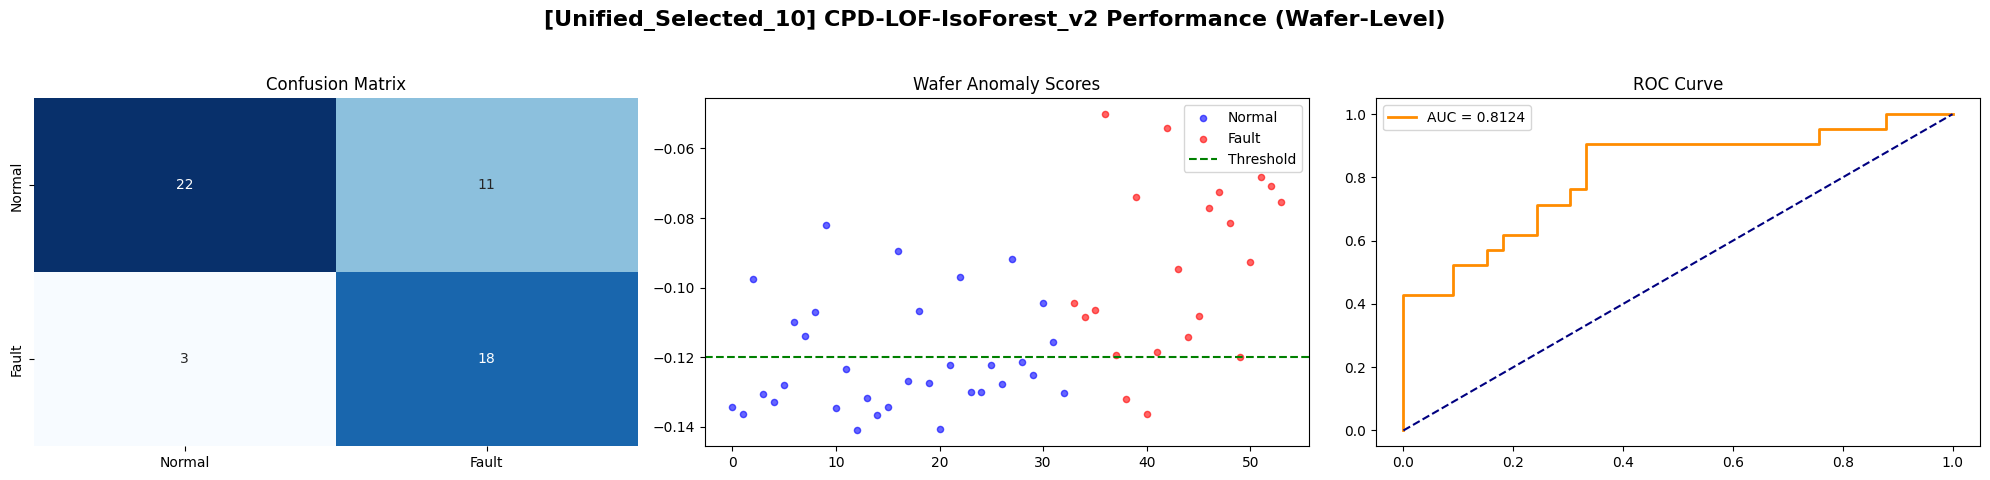

(np.float64(0.8124098124098125), np.float64(0.7450980392156863))

In [6]:
!pip install ruptures
import numpy as np
import pandas as pd
import ruptures as rpt
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest

# ==========================================
# 1. 핵심 Feature 선별 (TCP Tuner 제외 - 총 10개)
# ==========================================
# TCP Tuner를 제외한 10개 핵심 변수 리스트
selected_sensors = [
    'RF Impedance', 'TCP Load', 'RF Tuner', 'Endpt A', 'RF Load',
    'Pressure', 'RF Phase Err', 'TCP Impedance', 'TCP Phase Err',
    'TCP Top Pwr'
]

# 원본 19개 센서 내에서 해당 센서들의 인덱스 추출
sensor_to_idx = {name: i for i, name in enumerate(sensor_cols)}
selected_indices = [sensor_to_idx[s] for s in selected_sensors]

print(f"✅ 분석에 사용할 최종 핵심 센서 {len(selected_sensors)}개 선정 완료")
print(f"📊 선택된 센서: {selected_sensors}")

# ==========================================
# 2. 특징 추출 함수 (선택된 인덱스 반영 버전)
# ==========================================
def extract_lof_features_selected(X_data, selected_sensor_names, selected_idxs, n_bkps=4, k=25, saved_bkps=None):
    num_samples = X_data.shape[0]
    num_sensors = len(selected_sensor_names)
    num_segs = n_bkps + 1
    reduced_features = np.zeros((num_samples, num_sensors * num_segs))

    current_bkps = {}

    for i, (s_idx, sensor_name) in enumerate(zip(selected_idxs, selected_sensor_names)):
        # 1. 변화점(Breakpoints) 설정
        if saved_bkps is None:
            # [Train] 선택된 센서 데이터의 평균으로 변화점 탐지
            ref_signal = X_data[:, :, s_idx].mean(axis=0)
            model = rpt.Binseg(model="l2").fit(ref_signal)
            breakpoints = model.predict(n_bkps=n_bkps)
            current_bkps[sensor_name] = breakpoints
        else:
            # [Test] 사전에 정의된 변화점 사용
            breakpoints = saved_bkps[sensor_name]

        # 2. 세그먼트별 LOF 점수 계산
        start = 0
        for b_idx, end in enumerate(breakpoints):
            segment_data = X_data[:, start:end, s_idx]

            n_neighbors = min(k, segment_data.shape[0] - 1)
            lof = LocalOutlierFactor(n_neighbors=n_neighbors)
            lof.fit(segment_data)

            feature_idx = i * num_segs + b_idx
            reduced_features[:, feature_idx] = -lof.negative_outlier_factor_
            start = end

    return reduced_features, current_bkps

# ==========================================
# [Phase 1] 모델 학습 (정상 데이터 전용)
# ==========================================

print("\n🚀 [Phase 1] 모델 학습 시작 (10개 Features 적용)...")

# 1. 10개 센서에 대해서만 특징 추출
X_train_reduced, train_bkps = extract_lof_features_selected(
    datasets['Unified']['X_train'], selected_sensors, selected_indices, n_bkps=4, k=25
)

# 2. Isolation Forest 학습
iso_forest = IsolationForest(
    n_estimators=500,
    contamination='auto',
    random_state=42
)
iso_forest.fit(X_train_reduced)

print(f"✅ 학습 완료: {len(selected_sensors)}개 센서의 세그먼트별 LOF 분포를 학습했습니다.")

# ==========================================
# [Phase 2] 모델 평가 (테스트 데이터셋)
# ==========================================

print("\n🔍 [Phase 2] 테스트 데이터 평가 시작...")

# 1. 테스트 데이터 특징 추출 (동일한 10개 센서 및 학습 변화점 사용)
X_test_norm_reduced, _ = extract_lof_features_selected(
    datasets['Unified']['X_test_norm'], selected_sensors, selected_indices, saved_bkps=train_bkps
)
X_test_fault_reduced, _ = extract_lof_features_selected(
    datasets['Unified']['X_test_fault'], selected_sensors, selected_indices, saved_bkps=train_bkps
)

# 2. Isolation Forest 점수 산출
scores_norm_win = -iso_forest.decision_function(X_test_norm_reduced)
scores_fault_win = -iso_forest.decision_function(X_test_fault_reduced)

# 3. 웨이퍼 단위 점수 집계 (Method: Mean으로 과검 방지)
print("📈 웨이퍼 레벨 점수 집계 중...")
wafer_ids_norm, wafer_scores_norm = aggregate_wafer_scores(
    scores_norm_win, datasets['Unified']['ids_test_norm'], method='mean'
)
wafer_ids_fault, wafer_scores_fault = aggregate_wafer_scores(
    scores_fault_win, datasets['Unified']['ids_test_fault'], method='mean'
)

# 4. 평가 데이터 결합
final_scores = np.concatenate([wafer_scores_norm, wafer_scores_fault])
final_labels = np.concatenate([
    np.zeros(len(wafer_scores_norm)),
    np.ones(len(wafer_scores_fault))
])

# 5. 최종 성능 리포트
print("\n" + "="*60)
print("          CPD-LOF-IsoForest PERFORMANCE REPORT (10 Features)")
print("="*60)
evaluate_performance(
    model_name="CPD-LOF-IsoForest_v2",
    exp_id="Unified_Selected_10",
    scores=final_scores,
    labels=final_labels
)

🔍 정상 데이터 내 센서별 LOF 예민도 분석 중...


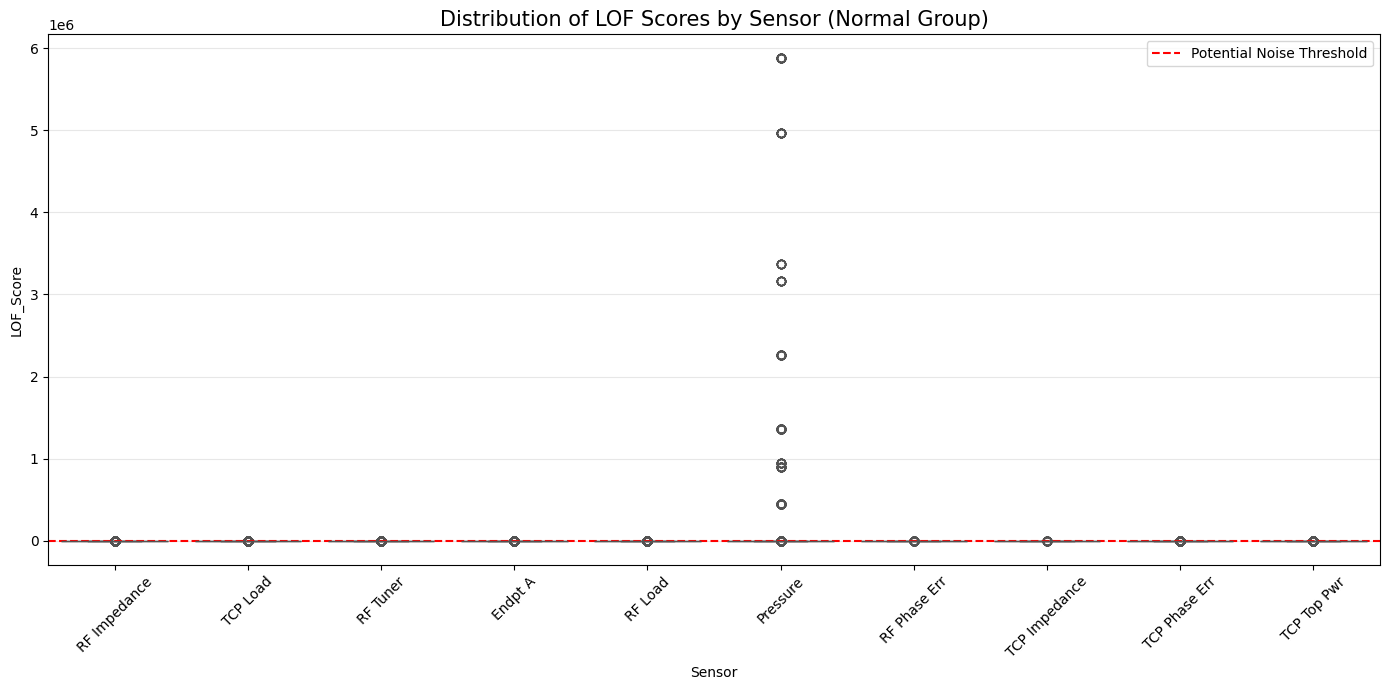


📊 [센서별 LOF 점수 요약 정보]
                       mean            std           max
Sensor                                                  
Pressure       91523.956144  571427.996219  5.875707e+06
TCP Load           1.160100       0.151118  2.089990e+00
TCP Impedance      1.137682       0.078450  1.555037e+00
RF Phase Err       1.120813       0.065196  1.420144e+00
TCP Phase Err      1.111341       0.067784  1.762428e+00
Endpt A            1.087515       0.107879  2.030779e+00
RF Impedance       1.078571       0.070499  1.765191e+00
RF Load            1.072318       0.051667  1.438615e+00
RF Tuner           1.063396       0.049444  1.354477e+00
TCP Top Pwr        1.061598       0.044238  1.343279e+00


In [7]:
'''
정확도 개선 (정상 웨이퍼를 불량으로 잡는 문제 발생)
하기위한 정상 웨이퍼의 센서 데이터 중 LOF 스코어가 높은 것 (이상으로 간주)
확인할 수 있는 시각화 코드
'''
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_sensor_lof_contribution(X_reduced, selected_sensor_names, n_segs=5):
    """
    각 센서별로 결합된 세그먼트 LOF 점수의 평균 분포를 분석
    """
    num_samples = X_reduced.shape[0]
    num_sensors = len(selected_sensor_names)

    # 센서별 평균 LOF 점수를 저장할 데이터프레임 생성
    sensor_lof_data = []

    for i, sensor_name in enumerate(selected_sensor_names):
        # 해당 센서에 속하는 모든 세그먼트(예: 5개)의 LOF 점수 추출
        start_col = i * n_segs
        end_col = (i + 1) * n_segs
        sensor_scores = X_reduced[:, start_col:end_col]

        # 세그먼트들의 평균값을 해당 센서의 대표 점수로 사용
        avg_lof_per_sample = sensor_scores.mean(axis=1)

        for score in avg_lof_per_sample:
            sensor_lof_data.append({'Sensor': sensor_name, 'LOF_Score': score})

    df_lof_analysis = pd.DataFrame(sensor_lof_data)

    # 시각화
    plt.figure(figsize=(14, 7))
    sns.boxplot(x='Sensor', y='LOF_Score', data=df_lof_analysis, palette='coolwarm')
    plt.xticks(rotation=45)
    plt.title('Distribution of LOF Scores by Sensor (Normal Group)', fontsize=15)
    plt.axhline(y=1.5, color='red', linestyle='--', label='Potential Noise Threshold') # 일반적인 LOF 경계선
    plt.grid(axis='y', alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 정량 수치 요약
    lof_summary = df_lof_analysis.groupby('Sensor')['LOF_Score'].agg(['mean', 'std', 'max']).sort_values(by='mean', ascending=False)
    print("\n📊 [센서별 LOF 점수 요약 정보]")
    print(lof_summary)
    return lof_summary

# 실행 (Phase 1에서 학습한 X_train_reduced 사용)
print("🔍 정상 데이터 내 센서별 LOF 예민도 분석 중...")
sensor_stability_report = analyze_sensor_lof_contribution(X_train_reduced, selected_sensors)

✅ 분석에 사용할 최종 핵심 센서 9개 선정 완료
📊 선택된 센서: ['RF Impedance', 'TCP Load', 'RF Tuner', 'Endpt A', 'RF Load', 'RF Phase Err', 'TCP Impedance', 'TCP Phase Err', 'TCP Top Pwr']

🚀 [Phase 1] 모델 학습 시작 (9개 Features 적용)...
✅ 학습 완료: 9개 센서의 세그먼트별 LOF 분포를 학습했습니다.

🔍 [Phase 2] 테스트 데이터 평가 시작...
📈 웨이퍼 레벨 점수 집계 중 (Method: Mean)...

          CPD-LOF-IsoForest PERFORMANCE REPORT (9 Features)

📌 [CPD-LOF-IsoForest_v3 - Unified_Selected_9] Wafer-Level Summary
   - AUROC         : 0.7475
   - Best F1-Score : 0.6667
   - Best Threshold: -0.070119


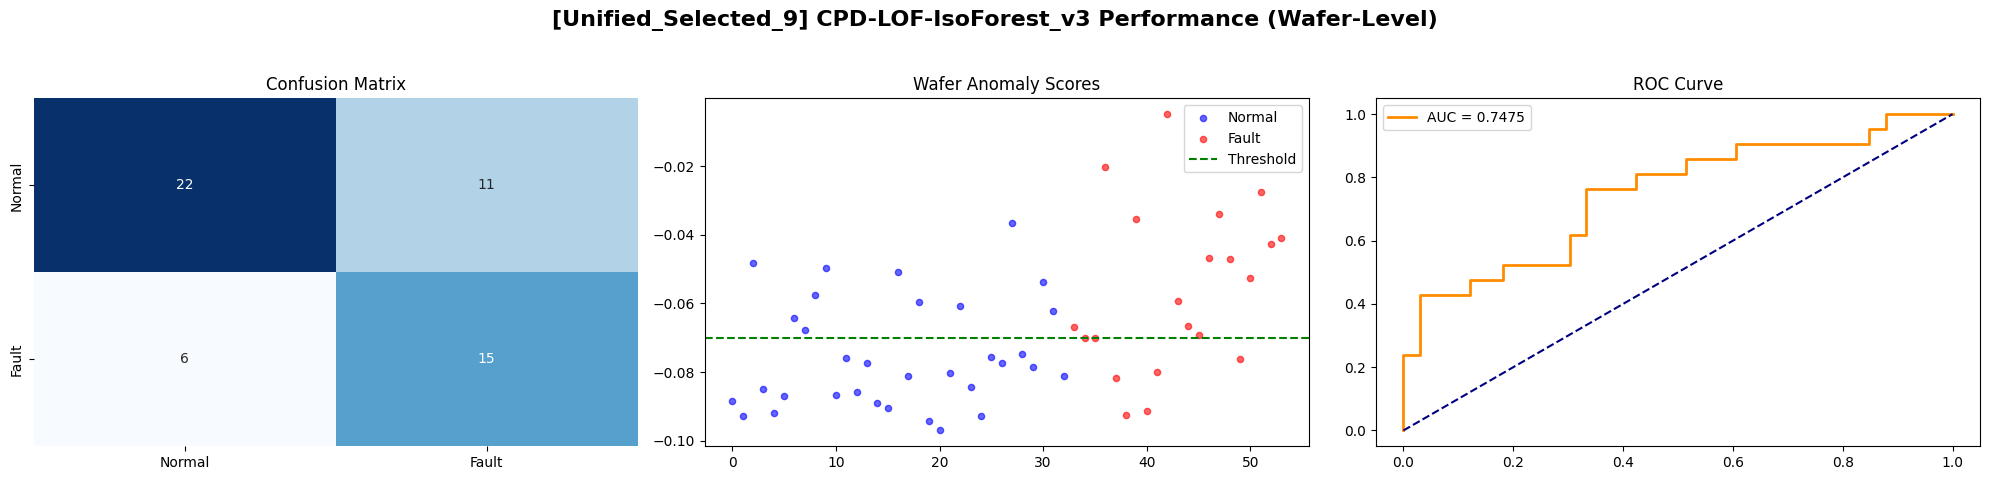

(np.float64(0.7474747474747475), np.float64(0.6666666666666666))

In [9]:
'''
위의 코드에서
Pressure의 LOF가 비정상적으로 높아
해당 Feature를 학습/추론에 반영하지 않는 버전
'''
!pip install ruptures
import numpy as np
import pandas as pd
import ruptures as rpt
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest

# ==========================================
# 1. 핵심 Feature 선별 (TCP Tuner 및 Pressure 제외 - 총 9개)
# ==========================================
# Pressure를 리스트에서 제거했습니다.
selected_sensors = [
    'RF Impedance', 'TCP Load', 'RF Tuner', 'Endpt A', 'RF Load',
    'RF Phase Err', 'TCP Impedance', 'TCP Phase Err', 'TCP Top Pwr'
]

# 원본 19개 센서 내에서 해당 센서들의 인덱스 추출
sensor_to_idx = {name: i for i, name in enumerate(sensor_cols)}
selected_indices = [sensor_to_idx[s] for s in selected_sensors]

print(f"✅ 분석에 사용할 최종 핵심 센서 {len(selected_sensors)}개 선정 완료")
print(f"📊 선택된 센서: {selected_sensors}")

# ==========================================
# 2. 특징 추출 함수 (기존 로직 유지)
# ==========================================
def extract_lof_features_selected(X_data, selected_sensor_names, selected_idxs, n_bkps=4, k=25, saved_bkps=None):
    num_samples = X_data.shape[0]
    num_sensors = len(selected_sensor_names)
    num_segs = n_bkps + 1
    reduced_features = np.zeros((num_samples, num_sensors * num_segs))

    current_bkps = {}

    for i, (s_idx, sensor_name) in enumerate(zip(selected_idxs, selected_sensor_names)):
        if saved_bkps is None:
            ref_signal = X_data[:, :, s_idx].mean(axis=0)
            model = rpt.Binseg(model="l2").fit(ref_signal)
            breakpoints = model.predict(n_bkps=n_bkps)
            current_bkps[sensor_name] = breakpoints
        else:
            breakpoints = saved_bkps[sensor_name]

        start = 0
        for b_idx, end in enumerate(breakpoints):
            segment_data = X_data[:, start:end, s_idx]

            n_neighbors = min(k, segment_data.shape[0] - 1)
            lof = LocalOutlierFactor(n_neighbors=n_neighbors)
            lof.fit(segment_data)

            feature_idx = i * num_segs + b_idx
            reduced_features[:, feature_idx] = -lof.negative_outlier_factor_
            start = end

    return reduced_features, current_bkps

# ==========================================
# [Phase 1] 모델 학습 (정상 데이터 전용)
# ==========================================

print(f"\n🚀 [Phase 1] 모델 학습 시작 ({len(selected_sensors)}개 Features 적용)...")

X_train_reduced, train_bkps = extract_lof_features_selected(
    datasets['Unified']['X_train'], selected_sensors, selected_indices, n_bkps=4, k=25
)

iso_forest = IsolationForest(
    n_estimators=500,
    contamination='auto',
    random_state=42
)
iso_forest.fit(X_train_reduced)

print(f"✅ 학습 완료: {len(selected_sensors)}개 센서의 세그먼트별 LOF 분포를 학습했습니다.")

# ==========================================
# [Phase 2] 모델 평가 (테스트 데이터셋)
# ==========================================

print("\n🔍 [Phase 2] 테스트 데이터 평가 시작...")

X_test_norm_reduced, _ = extract_lof_features_selected(
    datasets['Unified']['X_test_norm'], selected_sensors, selected_indices, saved_bkps=train_bkps
)
X_test_fault_reduced, _ = extract_lof_features_selected(
    datasets['Unified']['X_test_fault'], selected_sensors, selected_indices, saved_bkps=train_bkps
)

scores_norm_win = -iso_forest.decision_function(X_test_norm_reduced)
scores_fault_win = -iso_forest.decision_function(X_test_fault_reduced)

print("📈 웨이퍼 레벨 점수 집계 중 (Method: Mean)...")
wafer_ids_norm, wafer_scores_norm = aggregate_wafer_scores(
    scores_norm_win, datasets['Unified']['ids_test_norm'], method='mean'
)
wafer_ids_fault, wafer_scores_fault = aggregate_wafer_scores(
    scores_fault_win, datasets['Unified']['ids_test_fault'], method='mean'
)

final_scores = np.concatenate([wafer_scores_norm, wafer_scores_fault])
final_labels = np.concatenate([
    np.zeros(len(wafer_scores_norm)),
    np.ones(len(wafer_scores_fault))
])

print("\n" + "="*60)
print(f"          CPD-LOF-IsoForest PERFORMANCE REPORT ({len(selected_sensors)} Features)")
print("="*60)
evaluate_performance(
    model_name="CPD-LOF-IsoForest_v3",
    exp_id="Unified_Selected_9",
    scores=final_scores,
    labels=final_labels
)

🔍 'Pressure' 제외 후 9개 센서에 대한 예민도 분석을 시작합니다.


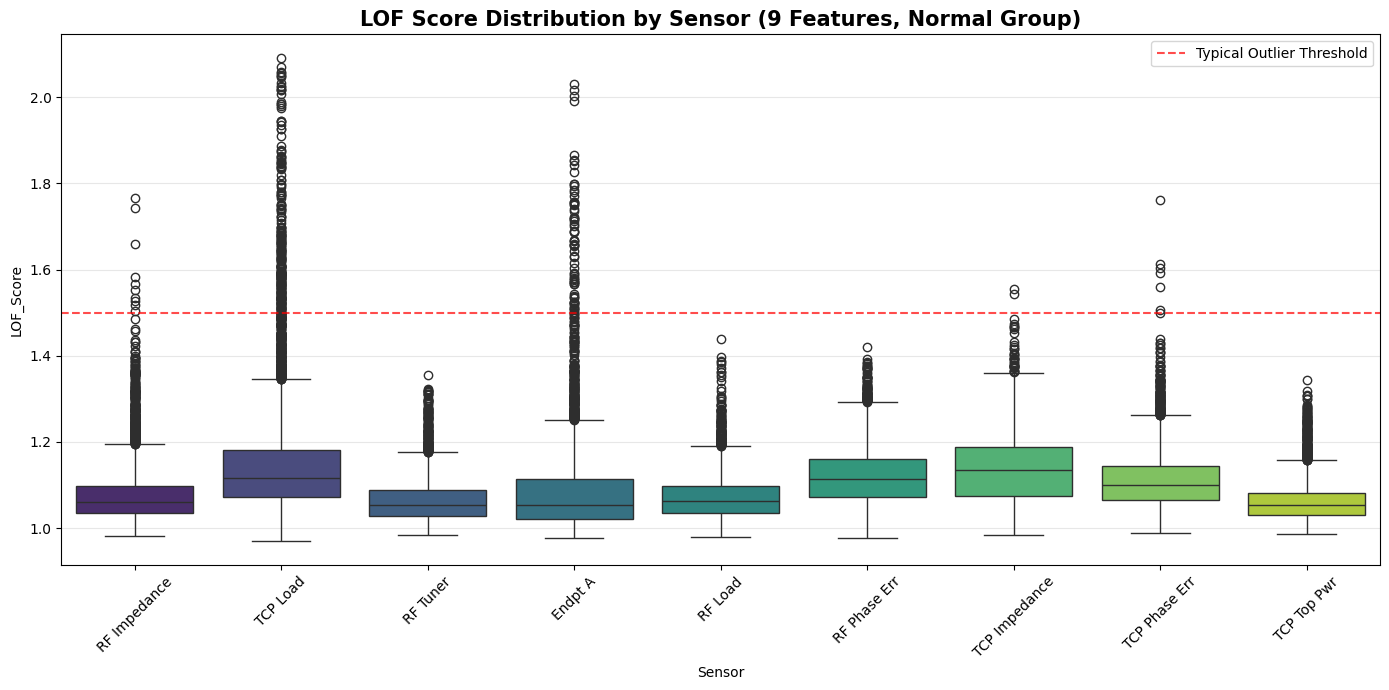


📋 [현재 9개 센서의 LOF 안정성 리포트]
                   mean       std       max
Sensor                                     
TCP Load       1.160100  0.151118  2.089990
TCP Impedance  1.137682  0.078450  1.555037
RF Phase Err   1.120813  0.065196  1.420144
TCP Phase Err  1.111341  0.067784  1.762428
Endpt A        1.087515  0.107879  2.030779
RF Impedance   1.078571  0.070499  1.765191
RF Load        1.072318  0.051667  1.438615
RF Tuner       1.063396  0.049444  1.354477
TCP Top Pwr    1.061598  0.044238  1.343279


In [10]:
'''
LOF 스코어 산정 시
정확도를 저해하는
튀는 값 확인용 코드
'''

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def analyze_sensor_lof_contribution_updated(X_reduced, selected_sensor_names, n_segs=5):
    """
    현재 선택된 센서들(9개)에 대해 세그먼트별 LOF 점수를 분석하여 시각화
    """
    num_samples = X_reduced.shape[0]
    num_sensors = len(selected_sensor_names)

    # 9개 센서 체제인지 확인
    if X_reduced.shape[1] != num_sensors * n_segs:
        print(f"⚠️ 경고: 입력 데이터의 차원({X_reduced.shape[1]})과 센서 수 기반 기대 차원({num_sensors * n_segs})이 불일치합니다.")

    sensor_lof_data = []

    for i, sensor_name in enumerate(selected_sensor_names):
        # 해당 센서의 세그먼트 인덱스 추출
        start_col = i * n_segs
        end_col = (i + 1) * n_segs
        sensor_scores = X_reduced[:, start_col:end_col]

        # 샘플별로 5개 세그먼트 점수의 평균을 냄 (센서별 대표 예민도)
        avg_lof_per_sample = sensor_scores.mean(axis=1)

        for score in avg_lof_per_sample:
            sensor_lof_data.append({'Sensor': sensor_name, 'LOF_Score': score})

    df_lof_analysis = pd.DataFrame(sensor_lof_data)

    # 시각화 설정
    plt.figure(figsize=(14, 7))
    # Boxplot으로 분포 확인 (색상은 점수가 높을수록 붉은색 계열)
    sns.boxplot(x='Sensor', y='LOF_Score', data=df_lof_analysis, palette='viridis')

    plt.xticks(rotation=45)
    plt.title(f'LOF Score Distribution by Sensor (9 Features, Normal Group)', fontsize=15, fontweight='bold')

    # LOF가 1.5 이상이면 보통 이상치로 간주하기 시작하는 기준선
    plt.axhline(y=1.5, color='red', linestyle='--', alpha=0.7, label='Typical Outlier Threshold')

    plt.grid(axis='y', alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 통계 요약
    lof_summary = df_lof_analysis.groupby('Sensor')['LOF_Score'].agg(['mean', 'std', 'max']).sort_values(by='mean', ascending=False)

    print("\n" + "="*50)
    print("📋 [현재 9개 센서의 LOF 안정성 리포트]")
    print("="*50)
    print(lof_summary)
    print("="*50)

    return lof_summary

# 1. 이전 단계에서 정의한 9개 센서 리스트를 사용
# selected_sensors = ['RF Impedance', 'TCP Load', 'RF Tuner', 'Endpt A', 'RF Load', 'RF Phase Err', 'TCP Impedance', 'TCP Phase Err', 'TCP Top Pwr']

# 2. 분석 실행 (반드시 9개 피처로 학습된 X_train_reduced를 넣어야 함)
print(f"🔍 'Pressure' 제외 후 {len(selected_sensors)}개 센서에 대한 예민도 분석을 시작합니다.")
stability_report = analyze_sensor_lof_contribution_updated(X_train_reduced, selected_sensors)

✅ 분석에 사용할 최종 핵심 센서 7개 선정 완료
📊 선택된 센서: ['RF Impedance', 'RF Tuner', 'RF Load', 'RF Phase Err', 'TCP Impedance', 'TCP Phase Err', 'TCP Top Pwr']

🚀 [Phase 1] 모델 학습 시작 (7개 Features 적용)...
✅ 학습 완료: 7개 센서의 세그먼트별 LOF 분포를 학습했습니다.

🔍 [Phase 2] 테스트 데이터 평가 시작...
📈 웨이퍼 레벨 점수 집계 중 (Method: Mean)...

          CPD-LOF-IsoForest PERFORMANCE REPORT (7 Features)

📌 [CPD-LOF-IsoForest_v4 - Unified_Selected_7] Wafer-Level Summary
   - AUROC         : 0.7460
   - Best F1-Score : 0.6562
   - Best Threshold: -0.154352


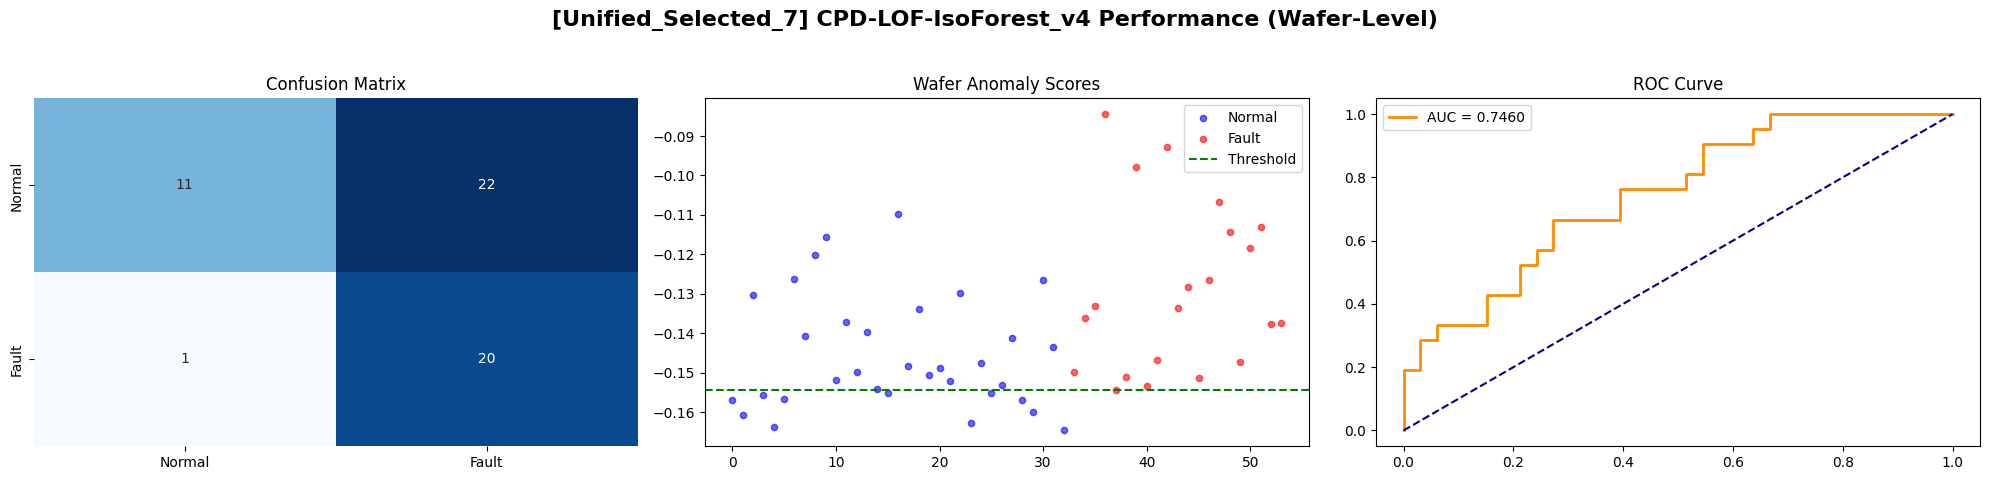

(np.float64(0.746031746031746), np.float64(0.65625))

In [13]:
'''
편차가 큰 TCP Load와 Endpt A까지 제거
'''
import numpy as np
import pandas as pd
import ruptures as rpt
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest

# ==========================================
# 1. 핵심 Feature 선별 (TCP Tuner, Pressure, TCP Load, Endpt A 제외 - 총 7개)
# ==========================================
# 노이즈를 유발하는 피처들을 리스트에서 제거했습니다.
selected_sensors = [
    'RF Impedance', 'RF Tuner', 'RF Load',
    'RF Phase Err', 'TCP Impedance', 'TCP Phase Err', 'TCP Top Pwr'
]

# 원본 19개 센서 내에서 해당 센서들의 인덱스 추출
sensor_to_idx = {name: i for i, name in enumerate(sensor_cols)}
selected_indices = [sensor_to_idx[s] for s in selected_sensors]

print(f"✅ 분석에 사용할 최종 핵심 센서 {len(selected_sensors)}개 선정 완료")
print(f"📊 선택된 센서: {selected_sensors}")

# ==========================================
# 2. 특징 추출 함수 (기존 로직 유지)
# ==========================================
def extract_lof_features_selected(X_data, selected_sensor_names, selected_idxs, n_bkps=4, k=25, saved_bkps=None):
    num_samples = X_data.shape[0]
    num_sensors = len(selected_sensor_names)
    num_segs = n_bkps + 1
    reduced_features = np.zeros((num_samples, num_sensors * num_segs))

    current_bkps = {}

    for i, (s_idx, sensor_name) in enumerate(zip(selected_idxs, selected_sensor_names)):
        if saved_bkps is None:
            # [Train] 변화점 탐지
            ref_signal = X_data[:, :, s_idx].mean(axis=0)
            model = rpt.Binseg(model="l2").fit(ref_signal)
            breakpoints = model.predict(n_bkps=n_bkps)
            current_bkps[sensor_name] = breakpoints
        else:
            # [Test] 저장된 변화점 사용
            breakpoints = saved_bkps[sensor_name]

        start = 0
        for b_idx, end in enumerate(breakpoints):
            segment_data = X_data[:, start:end, s_idx]

            n_neighbors = min(k, segment_data.shape[0] - 1)
            lof = LocalOutlierFactor(n_neighbors=n_neighbors)
            lof.fit(segment_data)

            # LOF 점수 저장
            feature_idx = i * num_segs + b_idx
            reduced_features[:, feature_idx] = -lof.negative_outlier_factor_
            start = end

    return reduced_features, current_bkps

# ==========================================
# [Phase 1] 모델 학습 (정상 데이터 전용)
# ==========================================

print(f"\n🚀 [Phase 1] 모델 학습 시작 ({len(selected_sensors)}개 Features 적용)...")

# 7개 센서에 대해서만 특징 추출
X_train_reduced, train_bkps = extract_lof_features_selected(
    datasets['Unified']['X_train'], selected_sensors, selected_indices, n_bkps=4, k=25
)

# Isolation Forest 학습 (안정성을 위해 n_estimators=500 유지)
iso_forest = IsolationForest(
    n_estimators=500,
    contamination='#auto',
    random_state=42
)
iso_forest.fit(X_train_reduced)

print(f"✅ 학습 완료: {len(selected_sensors)}개 센서의 세그먼트별 LOF 분포를 학습했습니다.")

# ==========================================
# [Phase 2] 모델 평가 (테스트 데이터셋)
# ==========================================

print("\n🔍 [Phase 2] 테스트 데이터 평가 시작...")

# 테스트 데이터 특징 추출 (학습 시 고정된 train_bkps 사용)
X_test_norm_reduced, _ = extract_lof_features_selected(
    datasets['Unified']['X_test_norm'], selected_sensors, selected_indices, saved_bkps=train_bkps
)
X_test_fault_reduced, _ = extract_lof_features_selected(
    datasets['Unified']['X_test_fault'], selected_sensors, selected_indices, saved_bkps=train_bkps
)

# iF 점수 산출
scores_norm_win = -iso_forest.decision_function(X_test_norm_reduced)
scores_fault_win = -iso_forest.decision_function(X_test_fault_reduced)

# 웨이퍼 단위 점수 집계 (Mean 방식)
print("📈 웨이퍼 레벨 점수 집계 중 (Method: Mean)...")
wafer_ids_norm, wafer_scores_norm = aggregate_wafer_scores(
    scores_norm_win, datasets['Unified']['ids_test_norm'], method='mean'
)
wafer_ids_fault, wafer_scores_fault = aggregate_wafer_scores(
    scores_fault_win, datasets['Unified']['ids_test_fault'], method='mean'
)

# 라벨 결합
final_scores = np.concatenate([wafer_scores_norm, wafer_scores_fault])
final_labels = np.concatenate([
    np.zeros(len(wafer_scores_norm)),
    np.ones(len(wafer_scores_fault))
])

# 성능 분석 리포트 출력
print("\n" + "="*60)
print(f"          CPD-LOF-IsoForest PERFORMANCE REPORT ({len(selected_sensors)} Features)")
print("="*60)
evaluate_performance(
    model_name="CPD-LOF-IsoForest_v4",
    exp_id="Unified_Selected_7",
    scores=final_scores,
    labels=final_labels
)